In [1]:
import os

try:
    import subprocess
    import sys

    from google.colab import drive

    subprocess.run(["pip", "install", "torchmetrics", "optuna"])
    base_dir = "/content/drive/MyDrive/Colab_Notebooks/Crack_Detection"
    drive.mount("/content/drive")
    sys.path.append(os.path.join(base_dir, "semantic-segmentation"))
    LOCAL = False
except ImportError:
    base_dir = "."
    LOCAL = True

import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import find_boundaries
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall
from torchmetrics.clustering import RandScore

from train import (
    DataLoader,
    ImageMaskTransform,
    SegmentationDataset,
    UNet,
    init_data_loaders,
    init_datasets,
    tune_hyperparams,
    train_fixed_hyperparams,
)


%load_ext tensorboard

Mounted at /content/drive


In [ ]:
%tensorboard --logdir {os.path.join(base_dir, "runs")}

In [ ]:
tune_hyperparams(base_dir, LOCAL)

In [ ]:
params = {
    "batch_size": 8,
    "brightness_prob": 0.3,
    "dropout_p": 0.5329,
    "elastic_prob": 0.03,
    "flip_prob": 0.3,
    "lr": 0.000363,
    "lr_cooldown": 40,
    "lr_factor": 0.7,
    "lr_patience": 45,
    "min_lr": 1e-7,
    "rotate_prob": 0.472,
    "translate_prob": 0.3,
    "loss_w0": 1.0,
    "loss_sigma": 5.0,
    "loss_w1": 0.0,
    "use_adam": True,
    "use_cosine_scheduler": False,
    "vanilla_loss": False,
}
num_epochs = 1200
min_save_epoch = 50
early_stop_patience = 200
num_workers = 2
best_error = train_fixed_hyperparams(
    base_dir,
    LOCAL,
    params,
    num_epochs,
    min_save_epoch,
    early_stop_patience,
    num_workers,
)
print(best_error)

Epoch 1/1200, Loss/train: 0.5969, RandError/train: 0.3538, PixelError/train: 0.2296, Recall/train: 1.0000, Precision/train: 0.7704, Loss/val: 0.5542, VanillaLoss/val: 0.6417, RandError/val: 0.3476, PixelError/val: 0.2240, Recall/val: 1.0000, Precision/val: 0.7760
Epoch 2/1200, Loss/train: 0.5501, RandError/train: 0.3527, PixelError/train: 0.2286, Recall/train: 1.0000, Precision/train: 0.7714, Loss/val: 0.4618, VanillaLoss/val: 0.5172, RandError/val: 0.3476, PixelError/val: 0.2240, Recall/val: 1.0000, Precision/val: 0.7760
Epoch 3/1200, Loss/train: 0.4588, RandError/train: 0.3546, PixelError/train: 0.2303, Recall/train: 1.0000, Precision/train: 0.7697, Loss/val: 0.3879, VanillaLoss/val: 0.4188, RandError/val: 0.3476, PixelError/val: 0.2240, Recall/val: 1.0000, Precision/val: 0.7760
Epoch 4/1200, Loss/train: 0.4012, RandError/train: 0.3190, PixelError/train: 0.1992, Recall/train: 0.9283, Precision/train: 0.8329, Loss/val: 0.3454, VanillaLoss/val: 0.3740, RandError/val: 0.2972, PixelError

In [ ]:
import pickle
import optuna.visualization as vis

# study_name = "study-0506-190624"
study_name = "study-0502-175711"
# study_name = "study-0428"
storage = f"sqlite:///Data/{study_name}/Data/seg-study.db"
studies = optuna.study.get_all_study_summaries(storage=storage)
print("Num of studies:", len(studies))
study = studies[-1]
print(study.study_name)

Num of studies: 14
study-0502-175709


In [ ]:
try:
    with open(f"Data/{study_name}/Data/studies/{study.study_name}.pkl", "rb") as f:
        study_dict = pickle.load(f)

    study = optuna.load_study(
        study_name=study.study_name,
        storage=storage,
        sampler=study_dict["sampler"],
        pruner=study_dict["pruner"],
    )
except FileNotFoundError:
    study = optuna.load_study(study_name=study.study_name, storage=storage)

In [ ]:
study.best_value, len(study.trials), study.pruner, study.best_params

(0.13715654611587524,
 47,
 {'flip_prob': 0.042747388239577966,
  'rotate_prob': 0.4719902190284881,
  'elastic_prob': 0.01567998717280196,
  'translate_prob': 0.15377448395168106,
  'brightness_prob': 0.138486416623626,
  'batch_size': 8,
  'dropout_p': 0.5328890961652364,
  'vanilla_loss': True,
  'use_adam': True,
  'lr': 0.00036296166101104416,
  'use_cosine_scheduler': False,
  'min_lr': 1.0017766083008169e-08,
  'lr_patience': 18,
  'lr_cooldown': 1,
  'lr_factor': 0.06925485872989952})

In [ ]:
study.best_value, len(study.trials), study.pruner, study.best_params

(0.14338421821594238,
 100,
 {'flip_prob': 0.04459255293028834,
  'rotate_prob': 0.40379419104333913,
  'elastic_prob': 0.014062767704262479,
  'translate_prob': 0.33608821897374763,
  'brightness_prob': 0.23828063471331679,
  'batch_size': 9,
  'dropout_p': 0.2887745942859943,
  'vanilla_loss': True,
  'use_adam': True,
  'lr': 0.0003909349124991186,
  'use_cosine_scheduler': False,
  'min_lr': 6.945255506527192e-08,
  'lr_patience': 24,
  'lr_cooldown': 1,
  'lr_factor': 0.2878405900553068})

In [ ]:
for trial in study.trials:
    params = trial.params
    if not params["vanilla_loss"]:
        v = trial.value
        if v and v < 0.25:
            print(f"{v:0.3f}", trial.number, trial.params, trial.state)

In [ ]:
optuna.importance.get_param_importances(study)

{'use_adam': np.float64(0.3977645095745252),
 'vanilla_loss': np.float64(0.1406793931554693),
 'elastic_prob': np.float64(0.08746186350862907),
 'batch_size': np.float64(0.08671901945241697),
 'use_cosine_scheduler': np.float64(0.08402969690245228),
 'brightness_prob': np.float64(0.06316926781526236),
 'translate_prob': np.float64(0.043377337361138406),
 'rotate_prob': np.float64(0.031254978146683376),
 'flip_prob': np.float64(0.025227132797285463),
 'min_lr': np.float64(0.021256423150298954),
 'dropout_p': np.float64(0.0190603781358387)}

In [ ]:
vis.plot_param_importances(study)

In [ ]:
(train_image_dir, train_images, train_mask_dir, val_images, val_percent) = (
    init_datasets(base_dir)
)

flip_prob = 0.1
rotate_prob = 0.1
elastic_prob = 0.11
translate_prob = 0.1
brightness_prob = 0.1
batch_size = 1 if LOCAL else 9
train_dataloader, val_dataloader = init_data_loaders(
    batch_size,
    brightness_prob,
    elastic_prob,
    flip_prob,
    rotate_prob,
    train_image_dir,
    train_images,
    train_mask_dir,
    translate_prob,
    val_images,
)

In [ ]:
for images, masks in train_dataloader:
    image = images[0].permute(1, 2, 0).cpu().numpy()
    mask = masks[0].cpu().numpy().squeeze()
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image, cmap="gray")
    axs[1].imshow(mask, cmap="gray")
    assert image.shape[:2] == (572, 572)
    assert mask.shape == (388, 388)
    plt.show()

In [5]:
dropout_p = 0.5329
batch_size = 8
vanilla_loss = True

test_image_dir = os.path.join(base_dir, "isbi_2012_challenge/test/imgs")
test_mask_dir = os.path.join(base_dir, "isbi_2012_challenge/test/labels")

test_images = os.listdir(test_image_dir)
test_transforms = ImageMaskTransform(train=False)
test_dataset = SegmentationDataset(
    test_image_dir, test_mask_dir, test_images, transform=test_transforms
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

pretrained_weights_path = os.path.join(base_dir, "checkpoints/run_0520-150800.pth")
model = UNet(dropout_p=dropout_p)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))
model.eval()

accuracy_metric_test = BinaryAccuracy().to(device)
precision_metric_test = BinaryPrecision().to(device)
recall_metric_test = BinaryRecall().to(device)
rand_score_metric_test = RandScore().to(device)
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        labels = labels.squeeze(1)
        preds = torch.argmax(outputs, dim=1)
        accuracy_metric_test.update(preds, labels)
        recall_metric_test.update(preds, labels)
        precision_metric_test.update(preds, labels)
        rand_score_metric_test.update(preds.view(-1), labels.view(-1))

print(
    f"Rand error: {1 - rand_score_metric_test.compute():.4f} "
    f"Pixel Error: {1 - accuracy_metric_test.compute():.4f} "
    f"Recall: {recall_metric_test.compute():.4f} "
    f"Precision: {precision_metric_test.compute():.4f}"
)

Rand error: 0.1831 Pixel Error: 0.1019 Recall: 0.9712 Precision: 0.8962


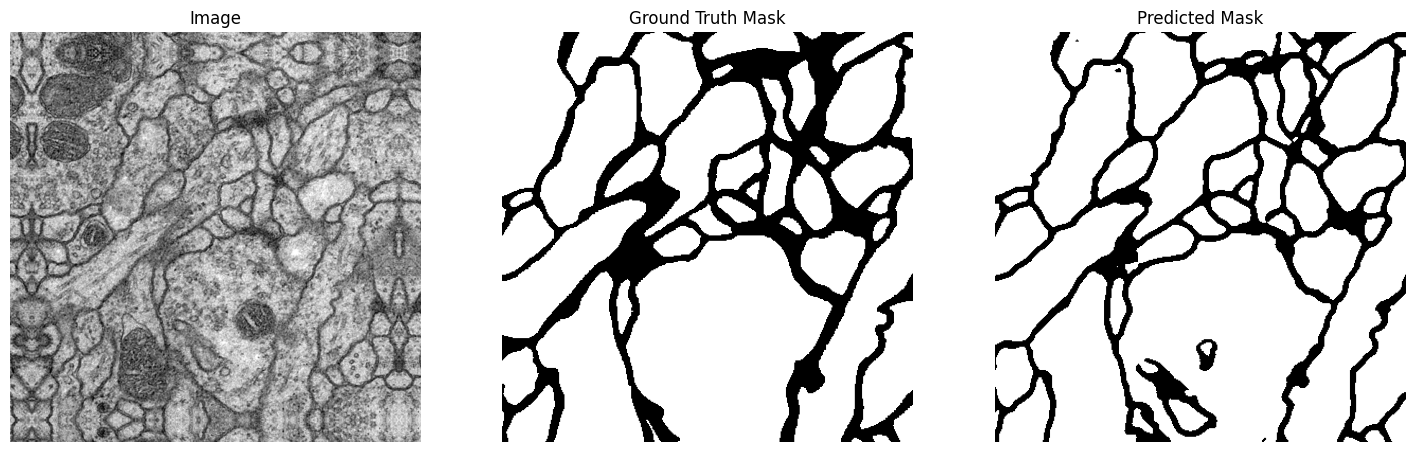

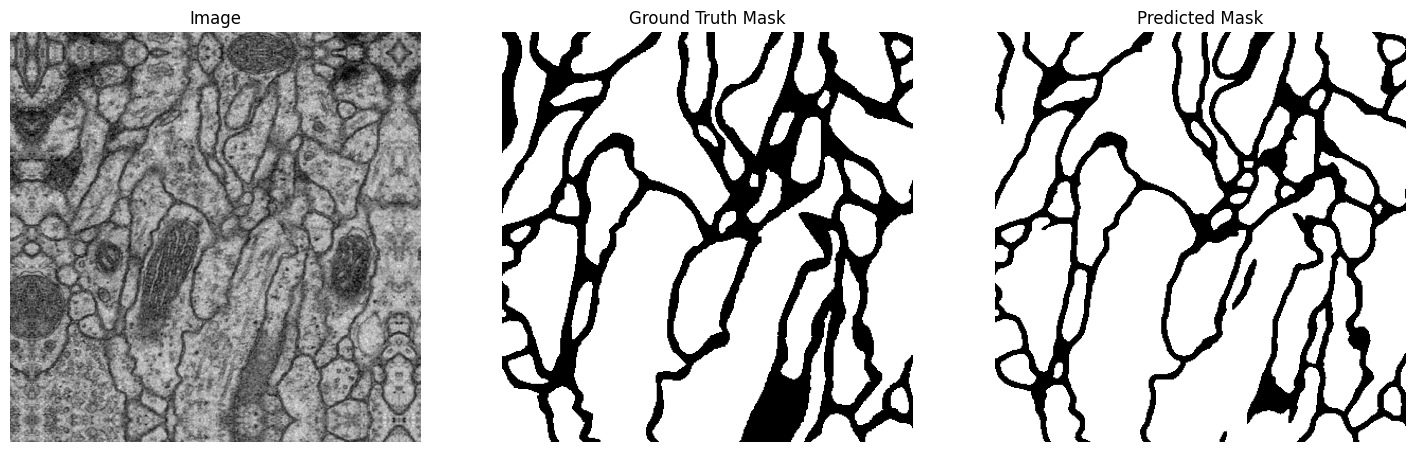

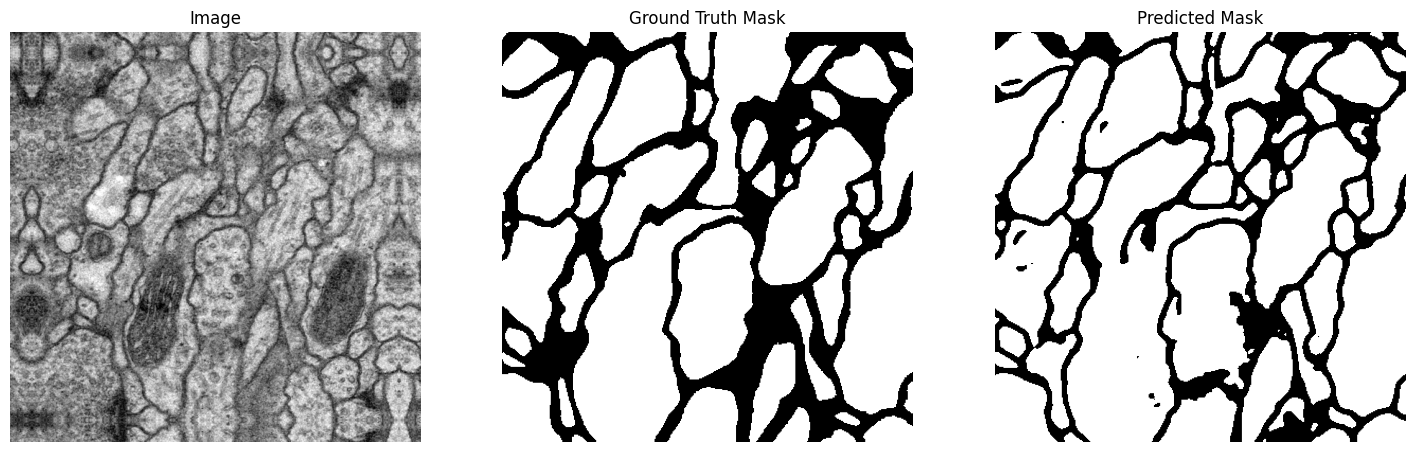

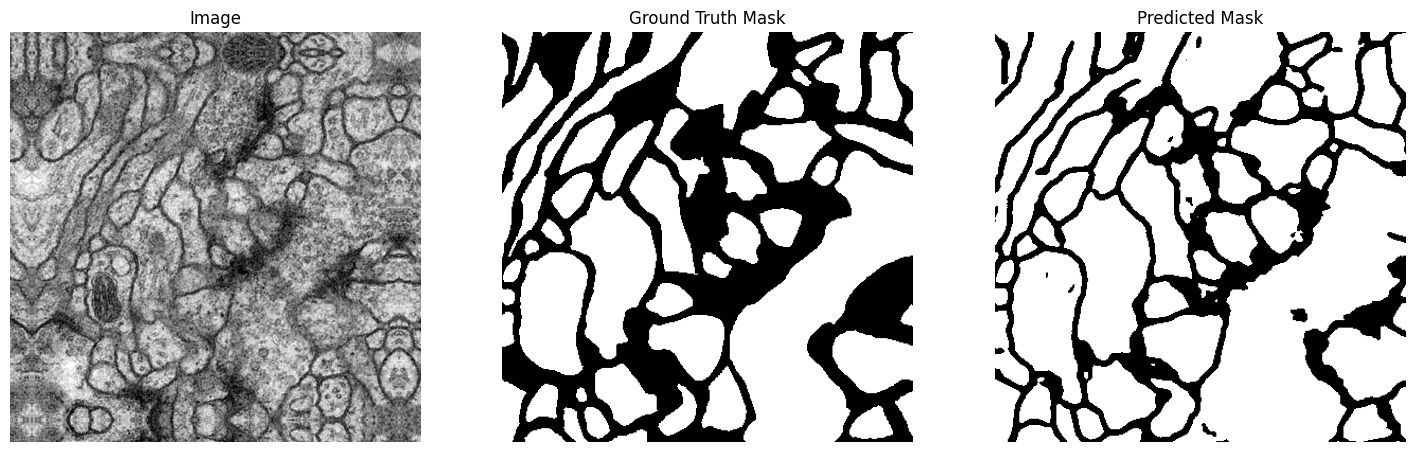

In [6]:
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        image = images[0].permute(1, 2, 0).cpu().numpy()
        mask = labels[0].cpu().numpy().squeeze()

        predicted_mask = torch.argmax(outputs[0], dim=0).cpu().numpy()

        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        axs[0].imshow(image, cmap="gray")
        axs[0].set_title("Image")
        axs[0].axis("off")

        axs[1].imshow(mask, cmap="gray")
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis("off")

        axs[2].imshow(predicted_mask, cmap="gray")
        axs[2].set_title("Predicted Mask")
        axs[2].axis("off")

plt.show()

In [ ]:
W0, SIGMA = 5, 5
for images, labels in train_dataloader:
    borders = find_boundaries(labels)
    dist = distance_transform_edt(~borders)
    w = W0 * np.exp(-2 * dist**2 / SIGMA**2)

    labels_bincount = torch.bincount(labels.flatten())
    w_class = labels_bincount.sum() / labels_bincount
    print(w_class, labels_bincount.sum())

    class_map = w_class[labels]
    print(class_map)

    w_final = class_map.numpy() + w

    fig, axs = plt.subplots(1, 4, figsize=(19, 6))
    axs[0].imshow(labels.squeeze(), cmap="gray")
    axs[1].imshow(~borders.squeeze(), cmap="gray")
    axs[2].imshow(w.squeeze(), cmap="coolwarm")
    axs[3].imshow(w_final.squeeze(), cmap="coolwarm")
    plt.show()
    plt.hist(w.flatten(), bins=10)
    plt.show()
    plt.hist(w_final.flatten(), bins=10)
    break